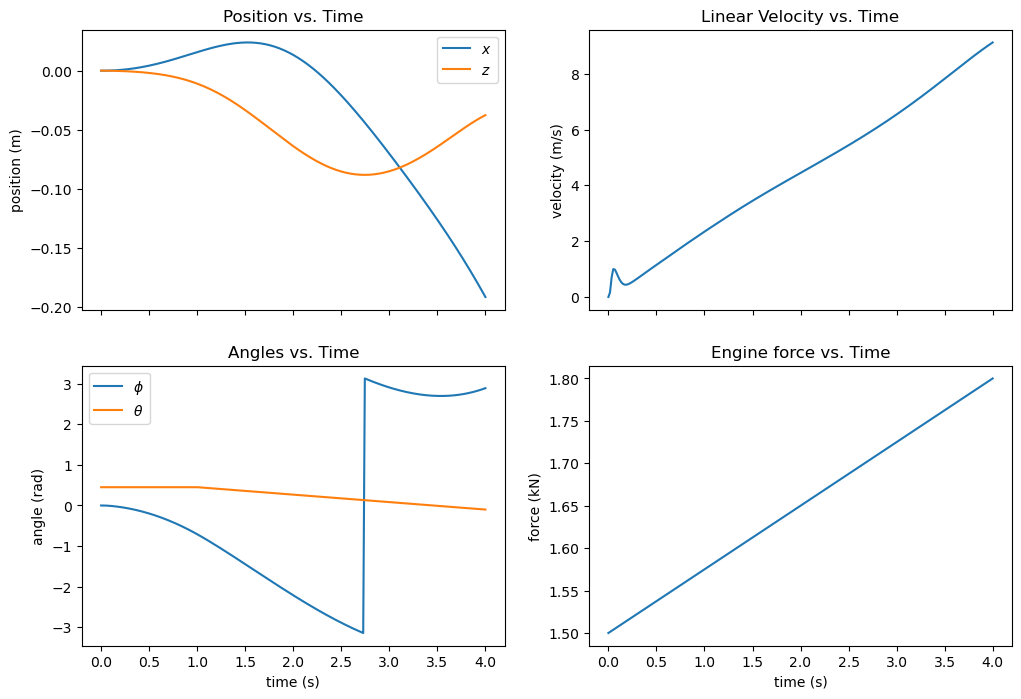

In [15]:
from hybrid_control_car import CarSimulation # The simulation developed for this project
import numpy as np
import scipy as sp
import control as ctrl
import matplotlib.pyplot as plt
import pysindy

nstates = 5 # The number of state variables (x, z, v, n_x, n_z)
ninputs = 2 # The number of inputs (F_e, phi)

def compute_phi(n_x, n_z) -> float:
    phi = 0.0
    
    if n_z == 0:
        if n_x == -1.0: phi = np.pi
    elif n_x == 0.0:
        if n_z == 1.0: phi = np.pi/2.0
        else: phi = 3*np.pi/2.0
    else:
        phi = np.arctan2(n_z, n_x)

    return phi

# Set up the simulation
sim = CarSimulation()
sim.create_floor()

hz = 60 # Timesteps per second
upm = 60 # Units per meter

def simulate(sim: CarSimulation, engine_force: float, steering_angle: float):
    # Convert force to kg*units/timestep^2
    engine_force = engine_force*(hz/upm**2)

    state, colliding, checkpoint, finish = sim.step(engine_force, steering_angle)
    state = np.array(state)
    # Convert units
    state[0] = state[0]/upm # x
    state[1] = state[1]/upm # z
    state[2] = state[2]*(hz/upm) # v

    return state, colliding, checkpoint, finish

def generate_training_data(sim: CarSimulation, rotation: float, nsamples, nstates, inputs):
    sim.reset_car(rotation)

    data = np.zeros((nsamples, nstates))
    # x, z, v, n_x, n_z
    x0 = np.array([0.0, 0.0, 0.0, np.cos(rotation), np.sin(rotation)])

    for n in range(nsamples):
        engine_force = inputs[n, 0]
        steering_angle = inputs[n, 1]
        state, _, _, _ = simulate(sim, engine_force, steering_angle)
        data[n, :] = x0
        x0 = state

    return data

def plot_data(t, state, input):
    x = state[:, 0]
    z = state[:, 1]
    v = state[:, 2]
    phi = np.arctan2(state[:, 4], state[:, 3])
    Fe = input[:, 0]
    Fe = Fe/1000 # Convert to kN
    theta = input[:, 1]

    fig, axs = plt.subplots(2, 2, sharex=True, figsize = (12, 8))
    axs = axs.flatten()

    axs[0].plot(t, x, label='$x$')
    axs[0].plot(t, z, label='$z$')
    axs[0].set_title("Position vs. Time")
    axs[0].set_ylabel("position (m)")
    axs[0].legend()

    axs[1].plot(t, v)
    axs[1].set_title("Linear Velocity vs. Time")
    axs[1].set_ylabel("velocity (m/s)")

    axs[2].plot(t, phi, label=r'$\phi$')
    axs[2].plot(t, theta, label=r"$\theta$")
    axs[2].set_title("Angles vs. Time")
    axs[2].set_xlabel("time (s)")
    axs[2].set_ylabel("angle (rad)")
    axs[2].legend()

    axs[3].plot(t, Fe)
    axs[3].set_title("Engine force vs. Time")
    axs[3].set_xlabel("time (s)")
    axs[3].set_ylabel("force (kN)")

nsteps_test = hz*4
t_test = np.linspace(0, nsteps_test, nsteps_test)
test_inputs = np.array([
    np.linspace(1500, 1800, nsteps_test),
    np.concatenate((
        0.45*np.ones(int(nsteps_test/4)),
        np.linspace(0.45, -0.1, 3*int(nsteps_test/4))
    ))
]).T
test_states = generate_training_data(sim, 0.0, nsteps_test, nstates, test_inputs)
t_test_seconds = t_test/hz

plot_data(t_test_seconds, test_states, test_inputs)

[-0.05037378 -0.21326697 22.62826324 -0.61794388  0.06863312]
[ 9.82677098e-05 -4.66812518e-05  8.71482432e-01  9.99975204e-01
 -7.04511581e-03]


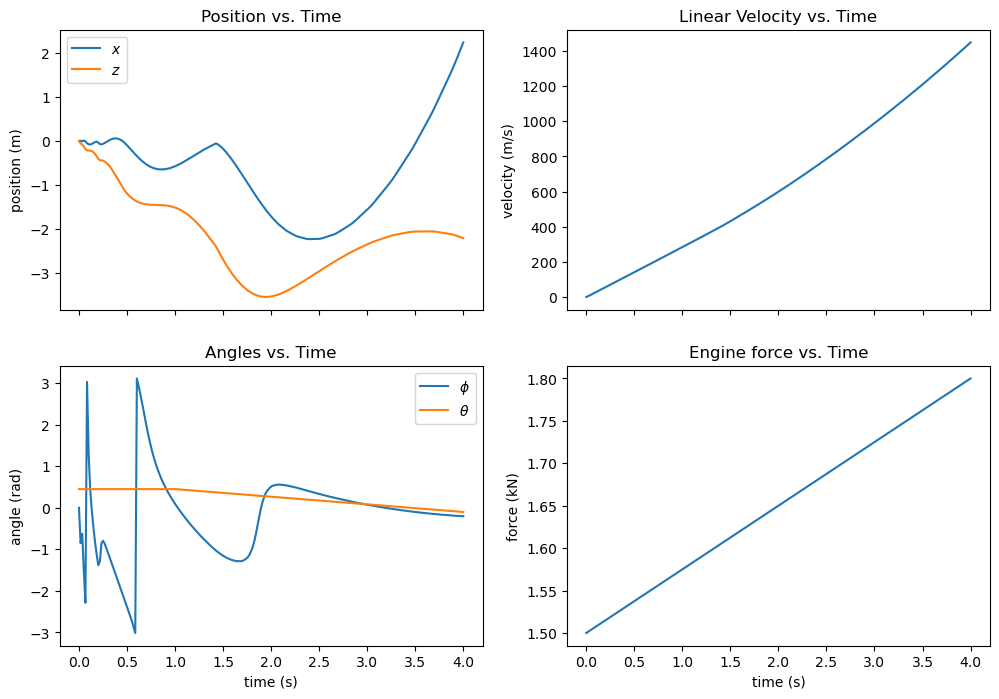

In [19]:
sim.reset_car(0.0)

def _simulation_update(_t, _x, u, params = {}):
    # Convert force to kg*units/timestep^2
    engine_force = u[0]*(hz/upm**2)
    steering_angle = u[1]

    state, _, _, _ = sim.step(engine_force, steering_angle)
    state = np.array(state)
    # Convert units
    state[0] = state[0]/upm # x
    state[1] = state[1]/upm # z
    state[2] = state[2]*(hz/upm) # v

    return state

def _simulation_output(_t, x, _u, params):
    return x



x0 = np.array([0.0, 0.0, 0.0, 1.0, 0.0])
simulation_sys = ctrl.NonlinearIOSystem(
    _simulation_update, _simulation_output, 
    states = ["x", "z", "v", "n_x", "n_z"], 
    inputs = ["Fe", "theta"],
    name = "simulation_sys"
)
system_states = ctrl.input_output_response(
    simulation_sys, T=t_test, U=test_inputs.T, X0=x0
).y

print(system_states[:, 5])
print(test_states[5, :])

plot_data(t_test_seconds, system_states.T, test_inputs)